## A usecase of using Random Forest from openEO: Dynamic Land Cover 

In this notebook, we will be studying land cover mapping. Land cover mapping has been done since the onset of remote sensing. Its products are essential for studying the functional and morphological changes in Earth's ecosystems and the environment. Therefore, it is vital in studying climate change and carbon circulation (Congalton et al., 2014; Feddema et al., 2005; Sellers et al., 1997). In addition to that, it provides valuable information for policy development and a wide range of applications within natural sciences and life sciences, making it one of the most widely studied applications within remote sensing (Yu et al., 2014; Tucker et al., 1985; Running, 2008; Yang et al., 2013).

With this variety in application fields comes a variety of user needs. Depending on the use case, significant differences may exist in the desired target labels, the requested target year(s), the needed output resolution, the used feature set, and the employed stratification strategy, among other factors. This use case aims to demonstrate how openEO handles this variability. We will achieve this by creating a user-friendly interface where users can set various parameters. This will tailor the pipeline — from reference set & L2A+GRD to model to inference — to the user's needs.

To see the most basic version of the dynamic land cover service, you can check out [this Python notebook](https://github.com/openEOPlatform/SRR3_notebooks/blob/main/notebooks/Demo%20UC9.ipynb). If you would like to have a look at some more advanced use cases, such as the use of stratification and the incorporation of extra datasets, have a look at [this Python notebook](https://github.com/openEOPlatform/SRR3_notebooks/blob/main/notebooks/Demo%20UC9%20with%20stratification.ipynb). This last notebook will show features that we will not show in this tutorial.

This notebook uses helper functionality from [this repository](https://github.com/openEOPlatform/openeo-classification). It contains, amongst others, the entire feature-building engineering workflow, so if you are interested in knowing how to do that or want to make more customizations towards your own use case, look at it. Note that the repository is not finalized and is generally used for other purposes.

![heelbelgie](https://user-images.githubusercontent.com/10434651/162210357-48389c4a-d58c-46da-972d-14f6ade2312e.png)

In [5]:
import openeo
from openeo.rest.mlmodel import MlModel
from openeo.extra.spectral_indices.spectral_indices import compute_and_rescale_indices
from openeo.processes import if_, is_nodata, array_concat, array_create
import geopandas as gpd
import pandas as pd
import json
from pathlib import Path
import datetime
from shapely.geometry import box
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

### Methodology

#### Reference data
The reference dataset used in this section is the Land Use/Cover Area Frame Survey (LUCAS) Copernicus dataset of 2018. LUCAS is an evenly spaced in-situ land use and land cover ground survey exercise extending over the entire European Union. The Copernicus module extends up to 51m in four cardinal directions to delineate polygons for each point. The final product contains about 60,000 polygons, from which subsequent points can be sampled (d'Andrimont et al., 2021). As a user, you can specify how many points to sample from these polygons to train your model. In addition, the user can upload extra target data to improve performance.

#### Input data
The service created runs on features constructed from GRD and L2A data. This data will be accessed through the Copernicus Data Space Ecosystem. As a user, you can determine a time range, though the year should be kept to 2018, as that is when the LUCAS Copernicus dataset was assembled. Data from other years can be extracted for prediction, provided the user uploads their reference set.

#### Preprocessing
The L2A data has been masked using the sen2cor sceneclassification, with a buffering approach developed at VITO and made available as a process called `mask_scl_dilation`. Backscatter is calculated from the Sentinel-1 GRD collection using the `sar_backscatter` process of openEO.


#### Feature engineering
We select and calculate the following products from our input collections:
- 7 indices (NDVI, NDMI, ANIR, NDRE1, NDRE2, NDRE5) and two bands (B06, B12) from the L2A collection
- VV, VH and VV/VH (ratio) from the GRD collection

As a user, you are, however, free to select other S2 indices; if you are interested in doing so, please refer to the [advanced notebook](https://github.com/openEOPlatform/SRR3_notebooks/blob/main/notebooks/Demo%20UC9%20with%20stratification.ipynb).

All layers are rescaled to 0 to 30000 for computational efficiency. The indices/bands are then aggregated temporally (for Sentinel-2 data: 10-day window using the median. For Sentinel-1 data, a 12-day window was used using the mean. The median was used for the S2 collection instead of the mean to prevent possible artefacts caused by cloud shadows). The output is then interpolated linearly, and the S1 cube is resampled spatially to a 10m resolution. Finally, ten features are calculated on each of the band dimensions. These ten features are the standard deviation, 25th, 50th and 75th percentile, and six equidistant t-steps. Through this procedure, we end up with 120 features (12 bands x 10 features).

#### Model
Where previously models had to be trained outside of openEO, we can now train Random Forest models in openEO itself. Hyperparameter tuning can be performed using a custom hyperparameter set. After training, the model is validated and used for prediction.


### Implementation
First, we load a dataset containing target labels. For the model to function correctly, these target labels must be integers. Additionally, we extract target points from the target polygons.

In [6]:
mask = box(4.4, 50.2, 5.6, 51.2)
y = gpd.read_file(
    "https://artifactory.vgt.vito.be/auxdata-public/openeo/LUCAS_2018_Copernicus.gpkg",
    mask=mask,
)
y["geometry"] = y["geometry"].apply(lambda x: x.centroid)
y["LC1"] = y["LC1"].apply(lambda x: ord(x[0]) - 65)
y_train, y_test = train_test_split(y, test_size=0.25, random_state=333)

In [7]:
y_train["target"] = y_train.LC1
y_train = y_train[["target", "geometry"]]
y_test["target"] = y_test.LC1
y_test = y_test[["target", "geometry"]]
y_train

,target,geometry
104,4,POINT (5.06096 50.65388)
150,4,POINT (5.1058 50.2232)
105,1,POINT (5.0552 50.70752)
201,4,POINT (5.31993 50.89871)
30,1,POINT (4.60356 51.17385)
...,...,...
110,5,POINT (5.11171 50.70987)
179,4,POINT (5.24289 51.09367)
163,1,POINT (5.23653 50.31891)
205,1,POINT (5.42265 50.72273)


In [8]:
c = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


Next, we will create the feature set to train a model. 
The indices used to calculate features can be adjusted by a parameter. However, if desired, you can create the entire feature engineering pipeline. If you are interested in learning how to do this, you can explore the openEO code in more detail [here](https://github.com/openEOPlatform/openeo-classification/blob/main/src/openeo_classification/features.py).

In [9]:
def connection():
    return c


# create sentinel-2 10-daily composite


def sentinel2_composite(
    start_date,
    end_date,
    connection_provider,
    provider,
    index_dict=None,
    s2_list=[],
    processing_opts={},
    sampling=False,
    stepsize=10,
    overlap=10,
    reducer="median",
    luc=False,
    cloud_procedure="sen2cor",
):
    """
    Compute a cloud-masked, gap-filled, Sentinel-2 datacube, composited at 10-daily intervals.
    """
    # define the temporal extent for the Sentinel-2 data
    temp_ext_s2 = [start_date.isoformat(), end_date.isoformat()]

    # properties to filter the data
    props = {"eo:cloud_cover": lambda v: v <= 80}

    bands = ["B03", "B04", "B05", "B06", "B07", "B08", "B11", "B12"]
    idx_list = ["NDVI", "NDMI", "NDRE1", "NDRE2", "NDRE5"]

    # establish a connection to the data source
    c = connection_provider()
    scl = c.load_collection(
        "SENTINEL2_L2A", temporal_extent=temp_ext_s2, bands="SCL", properties=props
    )
    cloud_mask = scl.process(
        "to_scl_dilation_mask",
        data=scl,
        kernel1_size=17, kernel2_size=77,
        mask1_values=[2, 4, 5, 6, 7],
        mask2_values=[3, 8, 9, 10, 11],
        erosion_kernel_size=3
    )
    s2 = c.load_collection(
        "SENTINEL2_L2A", temporal_extent=temp_ext_s2, bands=bands, properties=props
    )
    # apply cloud masking
    s2 = s2.mask(cloud_mask)

    #filter out the scl band
    s2 = s2.filter_bands(s2.metadata.band_names[:-1])

    # compute the spectral indices
    indices = compute_and_rescale_indices(s2, index_dict)

    # combine the original bands with the computed indices
    combined = s2.merge_cubes(indices)

    # filter the combined collection to include the desired bands and indices
    result_indices = combined.filter_bands(s2_list + idx_list)

    # aggregate the filtered collection to 10-daily intervals using the specified reducer
    idx_dekad = result_indices.aggregate_temporal_period("dekad", reducer="median")

    # apply linear interpolation to fill any temporal gaps
    idx_dekad = idx_dekad.apply_dimension(
        dimension="t", process="array_interpolate_linear"
    )
    return idx_dekad


# create Sentinel-1 12 day composite
def sentinel1_composite(
    start_date,
    end_date,
    connection_provider=connection,
    provider="Terrascope",
    processing_opts={},
    relativeOrbit=None,
    orbitDirection=None,
    sampling=False,
    stepsize=12,
    overlap=6,
    reducer="mean",
):
    """
    Compute a Sentinel-1 datacube, composited at 12-day intervals.
    """

    c = connection_provider()
    # define the temporal extent for the Sentinel-1 data
    temp_ext_s1 = [start_date.isoformat(), end_date.isoformat()]

    s1 = c.load_collection(
        "SENTINEL1_GRD", temporal_extent=temp_ext_s1, bands=["VH", "VV"]
    )

    # apply SAR backscatter processing to the collection
    s1 = s1.sar_backscatter(coefficient="sigma0-ellipsoid")

    # apply band-wise processing to create a ratio and log-transformed bands
    s1 = s1.apply_dimension(
        dimension="bands",
        process=lambda x: array_create(
            [
                30.0 * x[0] / x[1],  # Ratio of VH to VV
                30.0 + 10.0 * x[0].log(base=10),  # Log-transformed VH
                30.0 + 10.0 * x[1].log(base=10),  # Log-transformed VV
            ]
        ),
    )

    s1 = s1.rename_labels("bands", ["ratio"] + s1.metadata.band_names)

    # scale to int16
    s1 = s1.linear_scale_range(0, 30, 0, 30000)

    # aggregate the collection to 12-day intervals using the specified reducer
    s1_dekad = s1.aggregate_temporal_period(period="dekad", reducer="median")

    # apply linear interpolation to fill any temporal gaps
    s1_dekad = s1_dekad.apply_dimension(
        dimension="t", process="array_interpolate_linear"
    )
    return s1_dekad


def compute_statistics_fill_nan(base_features, start_date, end_date, stepsize):
    """
    Computes statistics over a datacube.
    For correct statistics, the datacube needs to be preprocessed to
    contain observation at equitemporal intervals, without nodata values.

    """

    def computeStats(input_timeseries, sample_stepsize, offset):
        tsteps = list(
            [
                input_timeseries.array_element(offset + sample_stepsize * index)
                for index in range(0, 6)
            ]
        )
        tsteps[1] = if_(is_nodata(tsteps[1]), tsteps[2], tsteps[1])
        tsteps[4] = if_(is_nodata(tsteps[4]), tsteps[3], tsteps[4])
        tsteps[0] = if_(is_nodata(tsteps[0]), tsteps[1], tsteps[0])
        tsteps[5] = if_(is_nodata(tsteps[5]), tsteps[4], tsteps[5])
        return array_concat(
            array_concat(
                input_timeseries.quantiles(probabilities=[0.25, 0.5, 0.75]),
                input_timeseries.sd(),
            ),
            tsteps,
        )

    tot_samples = (end_date - start_date).days // stepsize
    nr_tsteps = 6
    sample_stepsize = tot_samples // nr_tsteps
    offset = int(sample_stepsize / 2 + (tot_samples % nr_tsteps) / 2)

    features = base_features.apply_dimension(
        dimension="t",
        target_dimension="bands",
        process=lambda x: computeStats(x, sample_stepsize, offset),
    )

    tstep_labels = [
        "t" + str(offset + sample_stepsize * index) for index in range(0, 6)
    ]
    all_bands = [
        band + "_" + stat
        for band in base_features.metadata.band_names
        for stat in ["p25", "p50", "p75", "sd"] + tstep_labels
    ]
    features = features.rename_labels("bands", all_bands)
    return features


def load_lc_features(
    provider,
    feature_raster,
    start_date,
    end_date,
    stepsize_s2=10,
    stepsize_s1=12,
    processing_opts={},
    index_dict=None,
    connection_provider=connection,
):

    if not index_dict:
        idx_list = ["NDVI", "NDMI", "NDRE1", "NDRE2", "NDRE5"]
        s2_list = ["B06", "B12"]
        index_dict = {idx: [-1, 1] for idx in idx_list}
        index_dict["ANIR"] = [0, 1]

    final_index_dict = {
        "collection": {"input_range": [0, 8000], "output_range": [0, 30000]},
        "indices": {
            index: {"input_range": index_dict[index], "output_range": [0, 30000]}
            for index in index_dict
        },
    }

    idx_dekad = sentinel2_composite(
        start_date,
        end_date,
        connection_provider,
        provider,
        final_index_dict,
        s2_list,
        processing_opts=processing_opts,
        sampling=True,
        stepsize=stepsize_s2,
        luc=True,
    )
    idx_features = compute_statistics_fill_nan(
        idx_dekad, start_date, end_date, stepsize=stepsize_s2
    )

    s1_dekad = sentinel1_composite(
        start_date,
        end_date,
        connection_provider,
        provider,
        processing_opts=processing_opts,
        orbitDirection="ASCENDING",
        sampling=True,
        stepsize=stepsize_s1,
    )
    s1_features = compute_statistics_fill_nan(
        s1_dekad, start_date, end_date, stepsize=stepsize_s1
    )

    features = idx_features.merge_cubes(s1_features)

    return features, features.metadata.band_names

In [10]:
# Load land cover features from the specified source and time period
features, feature_list = load_lc_features(
    "cdse", "both", datetime.date(2022, 3, 1), datetime.date(2022, 10, 31)
)
X = features.aggregate_spatial(json.loads(y_train.to_json()), reducer="mean")

# Train a random forest classifier using the aggregated features
ml_model = X.fit_class_random_forest(
    target=json.loads(y_train.to_json()), num_trees=200
)
model = ml_model.save_ml_model()

In [11]:
job_options = {
    "executor-memory": "3G",
    "executor-memoryOverhead": "4G",
}

In [12]:
training_job = model.create_job(
    title="Training-job Dynamic LC", job_options=job_options
)
training_job.start_and_wait()

0:00:00 Job 'j-240809b753be447aa933a50d709f16e6': send 'start'
0:00:19 Job 'j-240809b753be447aa933a50d709f16e6': created (progress 0%)
0:00:25 Job 'j-240809b753be447aa933a50d709f16e6': created (progress 0%)
0:00:31 Job 'j-240809b753be447aa933a50d709f16e6': created (progress 0%)
0:00:40 Job 'j-240809b753be447aa933a50d709f16e6': created (progress 0%)
0:00:50 Job 'j-240809b753be447aa933a50d709f16e6': created (progress 0%)
0:01:02 Job 'j-240809b753be447aa933a50d709f16e6': queued (progress 0%)
0:01:18 Job 'j-240809b753be447aa933a50d709f16e6': queued (progress 0%)
0:01:37 Job 'j-240809b753be447aa933a50d709f16e6': queued (progress 0%)
0:02:01 Job 'j-240809b753be447aa933a50d709f16e6': queued (progress 0%)
0:02:31 Job 'j-240809b753be447aa933a50d709f16e6': queued (progress 0%)
0:03:14 Job 'j-240809b753be447aa933a50d709f16e6': queued (progress 0%)
0:04:00 Job 'j-240809b753be447aa933a50d709f16e6': running (progress N/A)
0:04:59 Job 'j-240809b753be447aa933a50d709f16e6': running (progress N/A)
0:05:

<BatchJob job_id='j-240809b753be447aa933a50d709f16e6'>

In [35]:
print(
    f""" The total openEO credits consumed when executing training the model is {training_job.describe()['costs']} credits."""
)

 The total openEO credits consumed when executing training the model is 220 credits.


In [13]:
results = training_job.get_results()
results.download_files()

[PosixPath('/home/jovyan/mystorage/3. openeo_examples/DynamicLC/randomforest.model.tar.gz'),
 PosixPath('/home/jovyan/mystorage/3. openeo_examples/DynamicLC/job-results.json')]

Subsequently, we can calculate several validation metrics from our test set. To achieve this, we perform inference for the points in our y-test set and write these predictions to a netCDF file. The function `calculate_validation_metrics` (a client-side helper function, not part of openEO itself) then load the y-test GeoJSON and the netCDF with predicted values. It extracts the points and stores the predicted values alongside their target labels in a dataframe.

In [14]:
links = results.get_metadata()["links"]
ml_model_metadata_url = [
    link for link in links if "ml_model_metadata.json" in link["href"]
][0]["href"]
print(ml_model_metadata_url)

https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-240809b753be447aa933a50d709f16e6/results/items/M2UyNGUyNTEtMmU5YS00MzhmLTkwYTktZDQ1MDBlNTc2NTc0/365f7aaf3b903a49377e075053f9881e/ml_model_metadata.json?expires=1723806581


In [15]:
model = MlModel.load_ml_model(connection=c, id=ml_model_metadata_url)

In [16]:
base_path = Path.cwd() / "results" / "testarea"
validation_path = base_path / "validation"
validation_path.mkdir(parents=True, exist_ok=True)

y_test.to_file(filename=str(validation_path / "y_test.geojson"), driver="GeoJSON")
cube = features
cube

In [17]:
predicted = (
    cube.predict_random_forest(model=model, dimension="bands")
    .linear_scale_range(0, 255, 0, 255)
    .aggregate_spatial(json.loads(y_test.to_json()), reducer="mean")
)  # "https://github.com/openEOPlatform/sample-notebooks/raw/main/resources/landcover/model_item.json"
test_job = predicted.execute_batch(
    out_format="CSV", title="dynamic land cover prediction"
)
test_job.get_results().download_files()

0:00:00 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': send 'start'
0:00:18 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': created (progress 0%)
0:00:23 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': created (progress 0%)
0:00:30 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': created (progress 0%)
0:00:38 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': running (progress N/A)
0:00:48 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': running (progress N/A)
0:01:00 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': running (progress N/A)
0:01:19 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': running (progress N/A)
0:01:43 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': running (progress N/A)
0:02:08 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': running (progress N/A)
0:02:38 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': running (progress N/A)
0:03:17 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': running (progress N/A)
0:04:04 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': running (progress N/A)
0:05:11 Job 'j-2408097b3f2d49a3bac281dd1f7198a7': running (progr

[PosixPath('/home/jovyan/mystorage/3. openeo_examples/DynamicLC/timeseries.csv'),
 PosixPath('/home/jovyan/mystorage/3. openeo_examples/DynamicLC/job-results.json')]

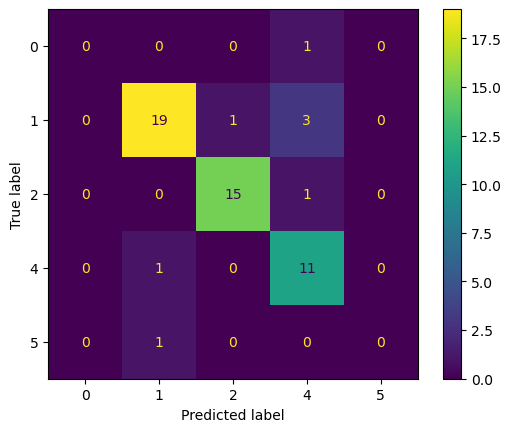

In [22]:
df = pd.read_csv("timeseries.csv")
df.index = df.feature_index
df = df.sort_index()
df.columns = ["feature_index", "predicted"]

gdf = gpd.read_file(validation_path / "y_test.geojson")
gdf["predicted"] = df.predicted.astype(int)
gdf = gdf.dropna()
ConfusionMatrixDisplay.from_predictions(gdf["target"], gdf["predicted"])

In [23]:
accuracy_score(gdf["target"], gdf["predicted"])

0.8490566037735849

After inspecting the metrics and possibly further fine-tuning the model or dataset, we can perform inference on an area of choice and write the results to a netCDF or GTiff. Happy mapping!

In [24]:
features, feature_list = load_lc_features(
    "cdse",
    "both",
    datetime.date(2022, 3, 1),
    datetime.date(2022, 10, 31),
    processing_opts=dict(tile_size=256),
)

cube = features.filter_bbox({"west": 5.1, "east": 5.2, "south": 50.7, "north": 50.8})
predicted = cube.predict_random_forest(
    model=model, dimension="bands"
).linear_scale_range(0, 255, 0, 255)
inf_job = predicted.execute_batch(out_format="GTiff")
inf_job.get_results().download_files()

0:00:00 Job 'j-24080930f4a34682a0297267a19fd772': send 'start'
0:00:18 Job 'j-24080930f4a34682a0297267a19fd772': created (progress 0%)
0:00:23 Job 'j-24080930f4a34682a0297267a19fd772': created (progress 0%)
0:00:35 Job 'j-24080930f4a34682a0297267a19fd772': created (progress 0%)
0:00:43 Job 'j-24080930f4a34682a0297267a19fd772': created (progress 0%)
0:01:00 Job 'j-24080930f4a34682a0297267a19fd772': created (progress 0%)
0:01:13 Job 'j-24080930f4a34682a0297267a19fd772': created (progress 0%)
0:01:29 Job 'j-24080930f4a34682a0297267a19fd772': running (progress N/A)
0:01:49 Job 'j-24080930f4a34682a0297267a19fd772': running (progress N/A)
0:02:20 Job 'j-24080930f4a34682a0297267a19fd772': running (progress N/A)
0:02:50 Job 'j-24080930f4a34682a0297267a19fd772': running (progress N/A)
0:03:27 Job 'j-24080930f4a34682a0297267a19fd772': running (progress N/A)
0:04:14 Job 'j-24080930f4a34682a0297267a19fd772': running (progress N/A)
0:05:13 Job 'j-24080930f4a34682a0297267a19fd772': running (progress

[PosixPath('/home/jovyan/mystorage/3. openeo_examples/DynamicLC/openEO.tif'),
 PosixPath('/home/jovyan/mystorage/3. openeo_examples/DynamicLC/job-results.json')]

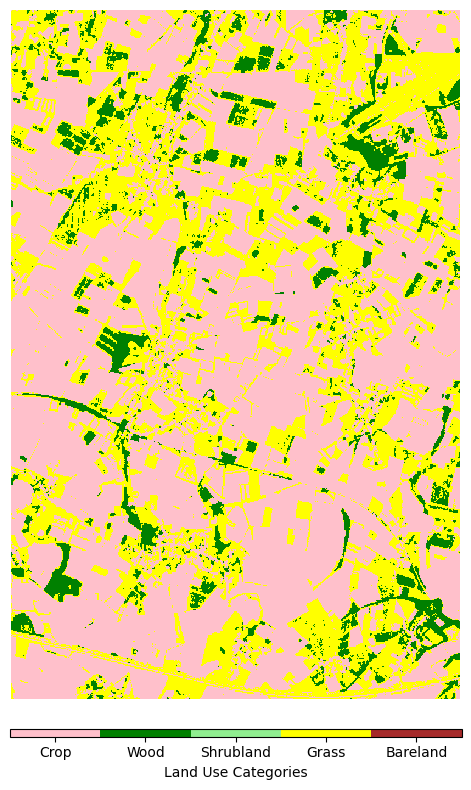

In [30]:
src = rasterio.open("openEO.tif")

categories = {"Crop": 1, "Wood": 2, "Shrubland": 3, "Grass": 4, "Bareland": 5}

# Define colors for each category
colors = ["pink", "green", "lightgreen", "yellow", "brown"]

# Create a colormap based on the defined colors
cmap = ListedColormap(colors, name="custom_cmap", N=len(colors))


plt.figure(figsize=(8, 8))
plt.imshow(
    src.read()[0], cmap=cmap, interpolation="nearest", vmin=1, vmax=len(colors) + 1
)
plt.axis("off")

# Add colorbar to show the correspondence between values and colors
cbar = plt.colorbar(
    ticks=np.arange(1.5, len(categories) + 1),
    aspect=55,
    orientation="horizontal",
    fraction=0.0113,
    pad=0.04,
)
cbar.ax.set_xticklabels(list(categories.keys()))
cbar.set_label("Land Use Categories")

plt.tight_layout()

Furthermore, the image below shows an example of the prediction results when tested over a large region.

![tile31UFS](https://user-images.githubusercontent.com/10434651/162389189-f20d8b4d-6509-4965-bf13-60590438d75c.png)